In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import root_mean_squared_error as rmse
import time
import tkinter as tk
from tkinter import messagebox
import math
import matplotlib as mpl

# our functions
import predict_Beta_I
import choice_start_day

import warnings
warnings.filterwarnings(action='ignore')

# to account for updates when files change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Main programm

In [93]:
def plot_one(ax, 
             predicted_days, seed_df, predicted_I, beggining_beta, predicted_beta,
             seed_number, execution_time,
             median_values, lower_bound, upper_bound):
    '''
    Построение графика для seed.
    
    Параметры:

    - ax -- область для графика
    - predicted_days -- дни предсказания
    - seed_df -- DataFrame of seed, созданный регулярной сетью
    - predicted_I -- предсказанные траектория компартмента Infected
    - beggining_beta -- предсказанные начальные значения Beta
    - predicted_beta -- предсказанные значения Beta
    - seed_number -- номер seed        
    - execution_time -- время предсказания Beta   
    - median_values -- выборочное среднее predicted_I в конкретный день
    - lower_bound -- верхняя граница интервала 3 стандартных отклонения predicted_I в конкретный день
    - upper_bound -- нижняя граница интервала 3 стандартных отклонения predicted_I в конкретный день
    '''

    # при сдвиге прогнозов иногда здесь нан
    predicted_I[np.isnan(predicted_I)] = 0.0  
    predicted_beta[np.isnan(predicted_beta)] = 0.0
    beggining_beta[np.isnan(beggining_beta)] = 0.0

    # Находим максимум и его индекс
    predicted_peak_I = max(predicted_I[0])
    predicted_peak_day = predicted_days[0] + np.argmax(predicted_I[0])
    actual_I = seed_df.iloc[:]['I'].values 
    actual_peak_I = max(actual_I)
    actual_peak_day = np.argmax(actual_I)+1

    peak = [actual_peak_I, predicted_peak_I,actual_peak_day,predicted_peak_day] 

    # подсчет RMSE для значений Infected и Beta
    actual_I = seed_df.iloc[predicted_days[0]:]['I'].values 
    rmse_I = rmse(actual_I, predicted_I[0])
    actual_Beta = seed_df.iloc[predicted_days[0]:]['Beta'].values 
    rmse_Beta = rmse(actual_Beta, predicted_beta)   

    # отображение границы перехода
    ax.axvline(predicted_days[0], color='red',ls=':')

    if predicted_I.shape[0] > 1:
        # отображение траекторий стохастической мат. модели
        for i in range(predicted_I.shape[0]-1):
            ax.plot(predicted_days, predicted_I[i+1], color='tab:orange', ls='--', 
                    alpha=0.3, label='Predicted I (stoch.)' if i == 0 else '')

        # Добавляем вертикальные линии с засечками для доверительных интервалов
        for day in range(0, len(predicted_days), 5):  # Проходим только по каждому 5-му дню
            ax.errorbar(predicted_days[day], median_values[day],
                        yerr=[[median_values[day] - lower_bound[day]], 
                            [upper_bound[day] - median_values[day]]], 
                        fmt='o', color='black', capsize=2, markersize=2, elinewidth=1, 
                        alpha=0.6, label='$\mu \pm 3\sigma$' if day == 0 else '')

    # отображение реальных и предсказанных значений Infected
    ax.plot(seed_df.index, seed_df.iloc[:]['I'].values , color='tab:blue', 
            label='Actual I')
    ax.plot(predicted_days, predicted_I[0],color='red', ls='-', 
              alpha=0.9, label='Predicted I (det.)')
    
    # добавление названий осей
    ax.set_xlabel('Days')
    ax.set_ylabel('Infected', color='blue')
    ax.grid(True, alpha=0.3)
        
    ax_b = ax.twinx()
    # отображение реальных и предсказанных значений beta
    ax_b.plot(seed_df.index, seed_df['Beta'],  color='gray', ls='--', 
              alpha=0.4, label='Actual Beta')
    
    if len(beggining_beta) > 0:
        given_days = np.arange(predicted_days[0])
        ax_b.plot(given_days, beggining_beta,color='green', ls='--', 
                  alpha=0.7, label='Predicted Beta ')
    ax_b.plot(predicted_days, predicted_beta,color='green', ls='--', 
              alpha=0.7, label='Predicted Beta ')
    ax_b.set_ylabel("Beta", color='green')
    
    # добавление легенды и заголовков
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_b.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax.set_title(f'Seed {seed_number}, Switch day {predicted_days[0]}\n'+
                 f'Peak I (act.):{actual_peak_I:.2f}, '+
                   f'Peak day (act.):{actual_peak_day:.2f}, \n' +
                 f'Peak I (pred.):{predicted_peak_I:.2f}, '+
                   f'Peak day (pred.):{predicted_peak_day:.2f}, \n' +
                 f'RMSE I:{rmse_I:.2f}, RMSE beta:{rmse_Beta:.2e}, \n'+
                 f'Predict time: {execution_time:.2e}' ,fontsize=10)
    return rmse_I, rmse_Beta, peak

def main_f(I_prediction_method, stochastic, count_stoch_line, 
           beta_prediction_method, type_start_day, seed_numbers,
           show_fig_flag, save_fig_flag):
    '''
    Основная функция
    
    Параметры:
    
    - I_prediction_method -- математическая модель для построения траектории Infected
        ['seir']
    - stochastic -- индикатор присутствия предсказанных стохастической мат. моделью траекторий Infected 
    - count_stoch_line -- количество предсказанных стохастической мат. моделью траекторий Infected 
    - beta_prediction_method -- метод предсказания значений Beta
        ['last_value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)'

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
    - type_start_day -- тип выбора дня переключения на мат. модель 
        (changing or constant)
        ['roll_var', 
         'norm_var', 
         'roll_var_seq', 
         'roll_var_npeople', 
         
         40,
         50,
         60]
    - seed_numbers -- номера seed для экспериментов
    - show_fig_flag -- флаг, показывать ли графики
    - save_fig_flag -- флаг, сохранять ли графики
    
    Выход:
        График для сидов.
    '''
    # устаноавление всегда постоянных значений параметров мат. модели
    sigma = 0.1
    gamma = 0.08
    if len(seed_numbers) > 1:
        row_n = len(seed_numbers)//2+math.ceil(len(seed_numbers)%2)
        fig, axes = plt.subplots(row_n, 2, figsize=(15, 4*row_n))
        axes = axes.flatten()
    
    # объявление папки с DataFrames of seeds, созданными регулярной сетью
    seed_dirs=f'{I_prediction_method}_30_seeds_v0/'
    
    # список RMSE Beta и I для каждого seed, чтобы изобразить boxplot
    all_rmse_I = []
    all_rmse_Beta = []
    all_peak = []
    start_days = []
    execution_time = []
    print(beta_prediction_method)
    for idx, seed_number in enumerate(seed_numbers):
        
        # чтение DataFrame of seed: S,[E],I,R,Beta
        seed_df = pd.read_csv(seed_dirs + f'{I_prediction_method}_seed_{seed_number}.csv')
        seed_df = seed_df[pd.notna(seed_df['Beta'])]

        # switch moment
        start_day = choice_start_day.choose_method(seed_df, type_start_day)
        start_days.append(start_day)
        # выбор дней для предсказания
        predicted_days = np.arange(start_day, seed_df.shape[0])
        
        start_time = time.time()
        # предсказание значений Beta и подсчет времени этого процесса
        beggining_beta, predicted_beta, predicted_I = predict_Beta_I.predict_beta(
                            I_prediction_method, seed_df, beta_prediction_method, predicted_days, 
                            stochastic, count_stoch_line, sigma, gamma)

        if (beta_prediction_method != 'regression (day, SEIR, previous I)') & (
            beta_prediction_method != 'lstm (day, E, previous I)'):
            # извлечение значений компартментов в день переключения на мат. модель
            y = seed_df.iloc[predicted_days[0]].drop('Beta')

            # предсказание траектория компартмента Infected
            _,_,predicted_I[0],_ = predict_Beta_I.predict_I(I_prediction_method, y, 
                                    predicted_days, 
                                    predicted_beta, sigma, gamma, 'det')
            if stochastic:
                for i in range(count_stoch_line):
                    _,_,predicted_I[i+1],_ = predict_Beta_I.predict_I(I_prediction_method, y, 
                                                predicted_days, 
                                                predicted_beta, sigma, gamma, 'stoch')
        end_time = time.time()
        execution_time.append(end_time - start_time)

        if len(seed_numbers) > 1:
            # построение графика для seed_number
            ax = axes[idx]
            rmse_I, rmse_Beta, peak = plot_one(ax, predicted_days, seed_df, 
                                            predicted_I, beggining_beta, predicted_beta, 
                                            seed_number, end_time - start_time, 0,0,0)        
            all_rmse_I.append(rmse_I)
            all_rmse_Beta.append(rmse_Beta)
            all_peak.append(peak)
    
    if len(seed_numbers) > 1:
        # добавление общего заголовка
        fig.suptitle(f'Switch {start_day} day, \n'+
                    f'I_prediction_method:{I_prediction_method}, \n'+
                    f'beta_prediction_method: {beta_prediction_method}' ,fontsize=15)
        plt.tight_layout()
        
        # сохранение графиков в pdf
        if save_fig_flag:
            beta_prediction_method = beta_prediction_method.replace(';\n','')
            plt.savefig(f'plots_var/seeds1 {beta_prediction_method}.pdf', 
                        format='pdf', dpi=300, bbox_inches='tight')
        
        # вывод графиков
        if show_fig_flag:
            plt.show()
        else:
            plt.close(fig)

        return all_rmse_I, all_rmse_Beta, all_peak, execution_time, start_days
    else :
        return predicted_days, seed_df, predicted_I, beggining_beta, predicted_beta, seed_number, end_time - start_time



# start day - changing


### Save RMSE Infected и Beta, peaks Infected and Day, predicted time, start day for all beta_prediction_method

In [ ]:
'''
seeds = set()
seeds.update(range(int(0), int(30)))
types_start_day = ['roll_var_seq', 
                   'roll_var_npeople']

for type_start_day in types_start_day:
    methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
    new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']
    for beta_prediction_method,new_labels in zip(methods, new_labels):
        all_rmse_I, all_rmse_Beta, all_peak, execution_time, start_days = main_f('seir', False, 0, beta_prediction_method, type_start_day, seeds, False, False)
        # Создание датафрейма для пиков
        all_peak = pd.DataFrame(all_peak, columns=['actual_peak_I', 'predicted_peak_I', 'actual_peak_day', 'predicted_peak_day'])
        # Создание датафрейма для RMSE, time, day
        print(len(all_rmse_I),len(all_rmse_Beta), len(execution_time), len(start_days))
        rmse_df = pd.DataFrame({
            'rmse_I': all_rmse_I,
            'rmse_Beta': all_rmse_Beta,
            'time_predict': execution_time,
            f'{type_start_day}': start_days})

        # Объединение датафреймов
        results = pd.concat([rmse_df, all_peak], axis=1)
        results.to_csv(f'results/type_start_day = {type_start_day}/{new_labels}_results.csv', index=False)''
'''

### Boxplot RMSE for Infected


type_start_day = roll_var_npeople

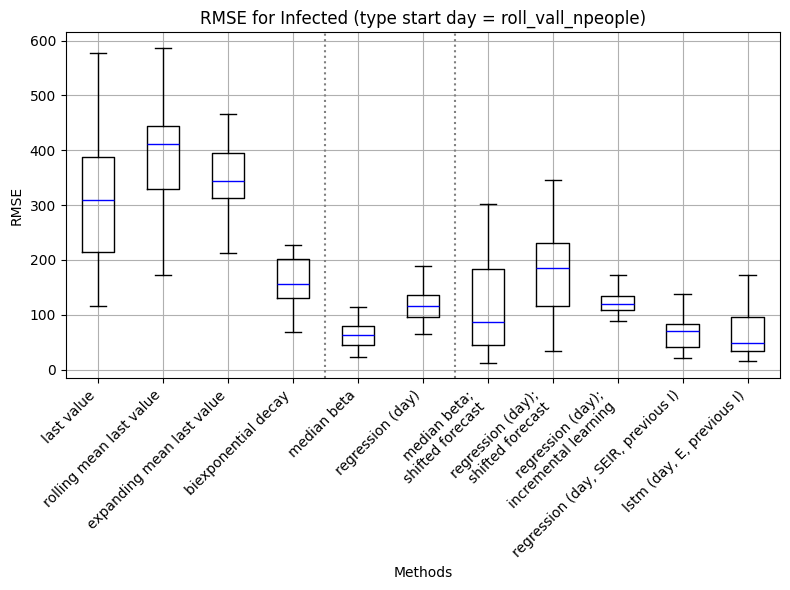

In [7]:
methods = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 
    
    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']
new_labels = ['last_value',
    'rolling_mean_last_value',
    'expanding_mean_last_value',
    'biexponential_decay', 
    
    'median_beta',
    'regression_day',

    'median_beta_shifted_forecast',
    'regression_day_shifted_forecast',
    'regression_day_incremental_learning',
    'regression_day_SEIR_previous_I',       
    'lstm_day_E_previous_I']

rmse_df = pd.DataFrame()
for beta_prediction_method,new_labels in zip(methods, new_labels):
    # Загрузка данных из CSV
    df = pd.read_csv(f'results/type_start_day = roll_var_npeople/{new_labels}_results.csv')
    # Добавляем данные в DataFrame с названием колонки как метод
    rmse_df[f"{beta_prediction_method}"] = df['rmse_I']

# Создание боксплота
plt.figure(figsize=(8,6))  # Установка размера графика
box = plt.boxplot(rmse_df, showfliers=False, medianprops=dict(color='blue'),widths=0.5)

# Настройка заголовка и меток
plt.title(f'RMSE for Infected (type start day = roll_vall_npeople)')
plt.xlabel('Methods')
plt.ylabel('RMSE')

# Поворот меток по оси X для лучшей читаемости
plt.xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
        labels=methods, rotation=45, ha='right')

plt.axvline(4.5, ls=':', color='gray')
plt.axvline(6.5, ls=':', color='gray')

# Показать график
plt.tight_layout()  # Автоматическая настройка отступов
plt.grid()
plt.savefig(f'results/type_start_day = roll_var_npeople/rmse_I_boxplot.pdf', format='pdf', dpi=300, bbox_inches='tight')    
plt.show()

last_value 309.3379823892012
rolling_mean_last_value 411.8019682392767
expanding_mean_last_value 343.88859784922465
biexponential_decay 156.05185476019625
median_beta 63.132295191818315
regression_day 115.00564494596907
median_beta_shifted_forecast 86.34916245706603
regression_day_shifted_forecast 184.3235819875726
regression_day_incremental_learning 119.91465189574632
regression_day_SEIR_previous_I 70.8644916972514
lstm_day_E_previous_I 47.989491611898245


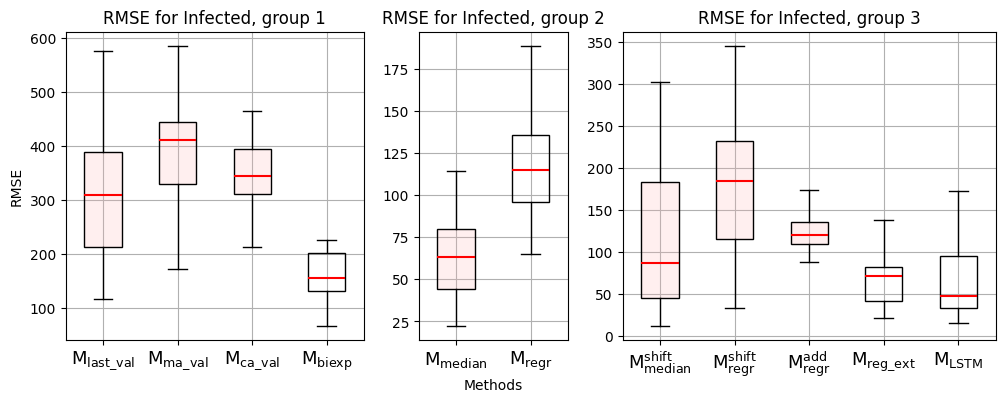

In [115]:
methods = [['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$'], 

    ['$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$'],

    ['$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']]
new_labels = [['last_value',
    'rolling_mean_last_value',
    'expanding_mean_last_value',
    'biexponential_decay'], 

    ['median_beta',
    'regression_day'],

    ['median_beta_shifted_forecast',
    'regression_day_shifted_forecast',
    'regression_day_incremental_learning',
    'regression_day_SEIR_previous_I',       
    'lstm_day_E_previous_I']]
switch = 'type_start_day = roll_var_npeople'

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[2,1,2.5]) 
#ax = ax.flatten()
for i in range(len(methods)):

    rmse_df = pd.DataFrame()
    for beta_prediction_method,new_label in zip(methods[i], new_labels[i]):
        # Загрузка данных из CSV
        df = pd.read_csv(f'results/{switch}/{new_label}_results.csv')
        # Добавляем данные в DataFrame с названием колонки как метод
        rmse_df[f"{beta_prediction_method}"] = df['rmse_I']
        print(new_label, df['rmse_I'].median())
    # Создание боксплота
    #plt.figure(figsize=(8*len(methods[i])/11+1,5))  # Установка размера графика
    ax = plt.subplot(gs[i])
    box = ax.boxplot(rmse_df[methods[i]], showfliers=False, 
                      medianprops=dict(color='red',linewidth=1.5), widths=0.5, patch_artist=True)

    median_c = (1.0, 0.7, 0.7, 0.2)
    lw=1
    for n, patch in enumerate(box['boxes']):
        if (i == 0) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 1) & (n < 1):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 2) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        else:
            patch.set(fill=False)  
        
    # Настройка заголовка и меток
    ax.set_title(f'RMSE for Infected, group {i+1}')
    if i==1:
        ax.set_xlabel('Methods')
    if i==0:
        ax.set_ylabel('RMSE')

    # Поворот меток по оси X для лучшей читаемости
    ax.set_xticks(ticks=np.arange(1, len(methods[i])+1), 
            labels=methods[i], rotation=0, ha='center', fontsize=13)
    
    # Показать график
    # with tightlayout() figsize changes depending on xlabels' lengths
    ax.grid()
    #plt.tight_layout()  # Автоматическая настройка отступов
    
   
plt.savefig(f'results/{switch}/rmse_I_3.pdf', 
            format='pdf', bbox_inches='tight')

### Boxplot RMSE for Beta


type_start_day = roll_var_npeople

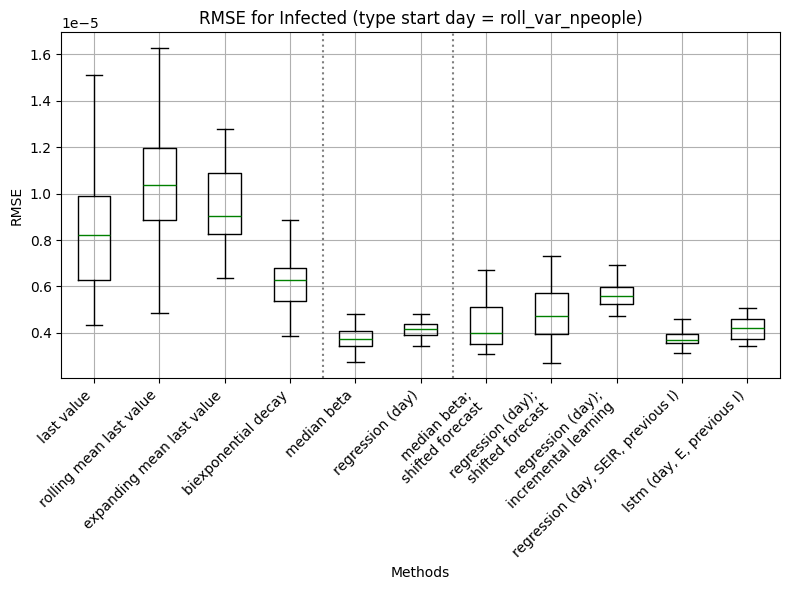

In [8]:
methods = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 
    
    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']
new_labels = ['last_value',
    'rolling_mean_last_value',
    'expanding_mean_last_value',
    'biexponential_decay', 
    
    'median_beta',
    'regression_day',

    'median_beta_shifted_forecast',
    'regression_day_shifted_forecast',
    'regression_day_incremental_learning',
    'regression_day_SEIR_previous_I',       
    'lstm_day_E_previous_I']

rmse_df = pd.DataFrame()
for beta_prediction_method,new_labels in zip(methods, new_labels):
    # Загрузка данных из CSV
    df = pd.read_csv(f'results/type_start_day = roll_var_npeople/{new_labels}_results.csv')
    # Добавляем данные в DataFrame с названием колонки как метод
    rmse_df[f"{beta_prediction_method}"] = df['rmse_Beta']

# Создание боксплота
plt.figure(figsize=(8,6))  # Установка размера графика
box = plt.boxplot(rmse_df, showfliers=False, medianprops=dict(color='green'),widths=0.5)

# Настройка заголовка и меток
plt.title(f'RMSE for Infected (type start day = roll_var_npeople)')
plt.xlabel('Methods')
plt.ylabel('RMSE')

# Поворот меток по оси X для лучшей читаемости
plt.xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
        labels=methods, rotation=45, ha='right')

plt.axvline(4.5, ls=':', color='gray')
plt.axvline(6.5, ls=':', color='gray')

# Показать график
plt.tight_layout()  # Автоматическая настройка отступов
plt.grid()
plt.savefig(f'results/type_start_day = roll_var_npeople/rmse_Beta_boxplot.pdf', format='pdf', dpi=300, bbox_inches='tight')    
plt.show()

last_value 8.235234350751468e-06
rolling_mean_last_value 1.0364678732531097e-05
expanding_mean_last_value 9.051364339178766e-06
biexponential_decay 6.294594429854524e-06
median_beta 3.7198801666434465e-06
regression_day 4.186300985784922e-06
median_beta_shifted_forecast 4.011823825699053e-06
regression_day_shifted_forecast 4.7367521611861115e-06
regression_day_incremental_learning 5.5854385485009145e-06
regression_day_SEIR_previous_I 3.7039159453114235e-06
lstm_day_E_previous_I 4.216700250324113e-06


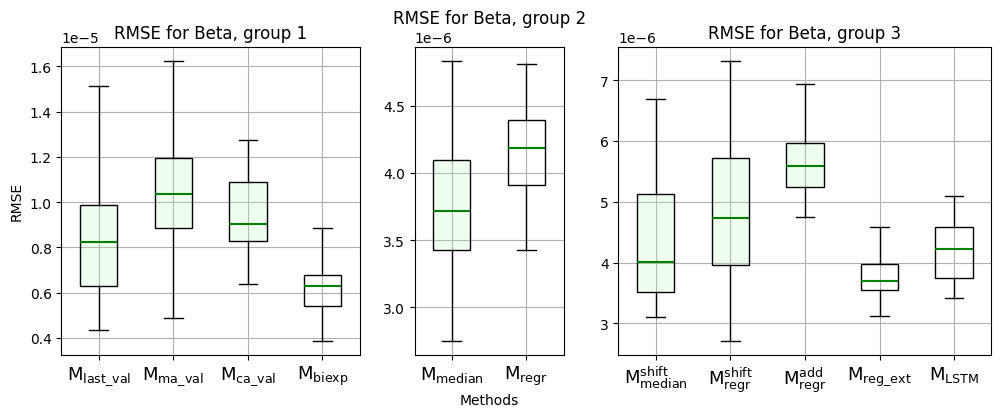

In [116]:
methods = [['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$'], 

    ['$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$'],

    ['$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']]
new_labels = [['last_value',
    'rolling_mean_last_value',
    'expanding_mean_last_value',
    'biexponential_decay'], 

    ['median_beta',
    'regression_day'],

    ['median_beta_shifted_forecast',
    'regression_day_shifted_forecast',
    'regression_day_incremental_learning',
    'regression_day_SEIR_previous_I',       
    'lstm_day_E_previous_I']]

switch = 'type_start_day = roll_var_npeople'

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[4,2,5]) 
#ax = ax.flatten()
for i in range(len(methods)):

    rmse_df = pd.DataFrame()
    for beta_prediction_method,new_label in zip(methods[i], new_labels[i]):
        # Загрузка данных из CSV
        df = pd.read_csv(f'results/{switch}/{new_label}_results.csv')
        # Добавляем данные в DataFrame с названием колонки как метод
        rmse_df[f"{beta_prediction_method}"] = df['rmse_Beta']
        print(new_label, df['rmse_Beta'].median())

    # Создание боксплота
    #plt.figure(figsize=(8*len(methods[i])/11+1,5))  # Установка размера графика
    ax = plt.subplot(gs[i])
    box = ax.boxplot(rmse_df[methods[i]], showfliers=False, 
                      medianprops=dict(color='green',linewidth=1.5), widths=0.5, patch_artist=True)


    median_c = (0.7, 1.0, 0.7, 0.2)
    lw=1
    for n, patch in enumerate(box['boxes']):
        if (i == 0) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 1) & (n < 1):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 2) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        else:
            patch.set(fill=False)  
        
    # Настройка заголовка и меток
    ax.set_title(f'RMSE for Beta, group {i+1}')
    if i==1:
        ax.set_xlabel('Methods')
    if i==0:
        ax.set_ylabel('RMSE')

    # Поворот меток по оси X для лучшей читаемости
    ax.set_xticks(ticks=np.arange(1, len(methods[i])+1), 
            labels=methods[i], rotation=0, ha='center', fontsize=13)
    
    # Показать график
    # with tightlayout() figsize changes depending on xlabels' lengths
    ax.grid()
    #plt.tight_layout()  # Автоматическая настройка отступов
    
   
plt.savefig(f'results/{switch}/rmse_Beta_3.pdf', 
            format='pdf', bbox_inches='tight')

### Show peaks plots

type_start_day = roll_var_npeople

In [12]:
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']


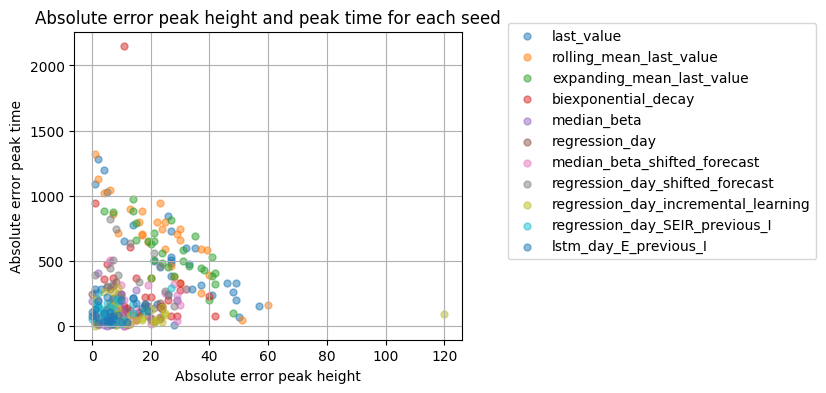

In [13]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
for name in new_labels:
    p_df = pd.read_csv(f'results/type_start_day = roll_var_npeople/{name}_results.csv')
    
    ax.scatter(abs(p_df['actual_peak_day']-p_df['predicted_peak_day']),
               abs(p_df['actual_peak_I']-p_df['predicted_peak_I']),
               marker='.', s=100,  alpha=0.5, label=name)
    
ax.set_title('Absolute error peak height and peak time for each seed')    
ax.set_xlabel('Absolute error peak height')
ax.set_ylabel('Absolute error peak time')
ax.legend(bbox_to_anchor=(1.1, 1.05))

ax.grid()
plt.savefig(f'results/type_start_day = roll_var_npeople/absolute_error_peaks.pdf', format='pdf', dpi=300, bbox_inches='tight')

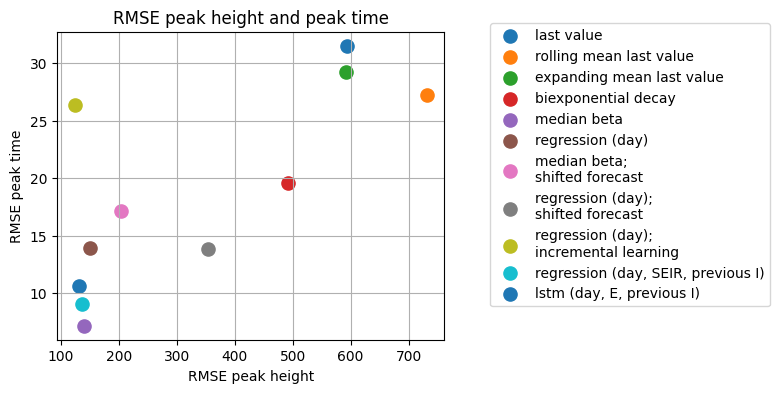

In [14]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
rmse_ph = []
rmse_pt = []
for name in new_labels:
    p_df = pd.read_csv(f'results/type_start_day = roll_var_npeople/{name}_results.csv')
    rmse_ph.append(rmse(p_df.iloc[:]['actual_peak_I'], p_df.iloc[:]['predicted_peak_I']))
    rmse_pt.append(rmse(p_df.iloc[:]['actual_peak_day'], p_df.iloc[:]['predicted_peak_day']))
    
for i, name in enumerate(methods):   
    ax.scatter(rmse_ph[i], rmse_pt[i], marker='o', s=90, label=name)
    
ax.set_title('RMSE peak height and peak time')    
ax.set_xlabel('RMSE peak height')
ax.set_ylabel('RMSE peak time')
ax.legend(bbox_to_anchor=(1.1, 1.05))

ax.grid()

plt.savefig(f'results/type_start_day = roll_var_npeople/rmse_peaks.pdf', format='pdf', dpi=300, bbox_inches='tight')


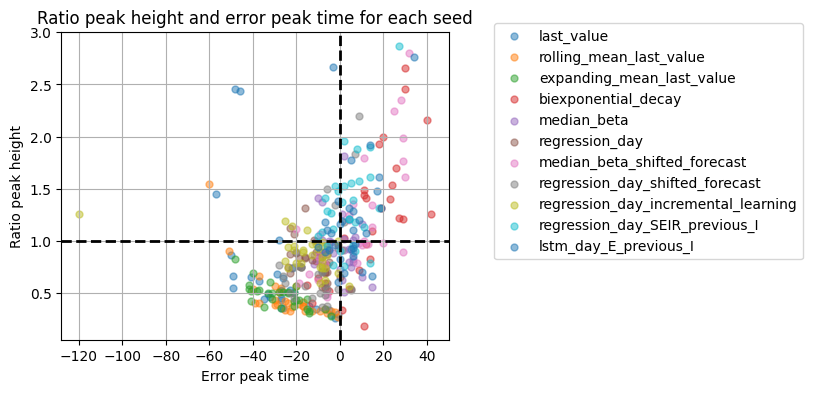

In [15]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))

for name in new_labels:
    p_df = pd.read_csv(f'results/type_start_day = roll_var_npeople/{name}_results.csv')
    ph = []
    pt = []
    ph.append([p_df.iloc[:]['actual_peak_I']/p_df.iloc[:]['predicted_peak_I']])
    pt.append([p_df.iloc[:]['actual_peak_day']-p_df.iloc[:]['predicted_peak_day']])
    
    ax.scatter(pt,ph, marker='.', s=100,  alpha=0.5, label=name)
ax.set_title('Ratio peak height and error peak time for each seed')    
ax.set_xlabel('Error peak time')
ax.set_ylabel('Ratio peak height')
ax.legend(bbox_to_anchor=(1.1, 1.05))

ax.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Difference of peak time=0')
ax.axhline(y=1, color='black', linestyle='--', linewidth=2, label='Ratio of peak height=1')
ax.grid()

plt.savefig(f'results/type_start_day = roll_var_npeople/ratio_and_error_peaks.pdf', format='pdf', dpi=300, bbox_inches='tight')


In [ ]:
new_labels = ['last_value', 'rolling_mean_last_value',
                'expanding_mean_last_value','biexponential_decay', 

                'median_beta','regression_day',

                'median_beta_shifted_forecast','regression_day_shifted_forecast',
                'regression_day_incremental_learning','regression_day_SEIR_previous_I',       
                'lstm_day_E_previous_I']


switch = 'type_start_day = roll_var_npeople'

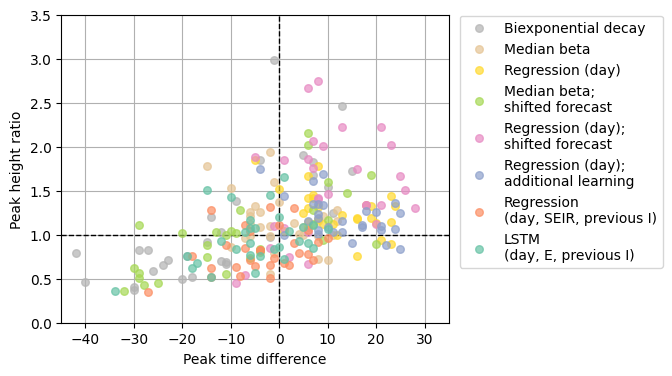

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))

ax.axvline(x=0, color='black', linestyle='--', 
           linewidth=1)
ax.axhline(y=1, color='black', linestyle='--', 
           linewidth=1)

methods = ['Biexponential decay', 'Median beta', 'Regression (day)',

            'Median beta;\nshifted forecast',
            'Regression (day);\nshifted forecast',
            'Regression (day);\nadditional learning',
            'Regression\n(day, SEIR, previous I)',       
            'LSTM\n(day, E, previous I)']
cmap = mpl.colormaps['Set2']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, 8))
colors = list(colors)

for name, method in zip(new_labels[3:], methods):
    p_df = pd.read_csv(f'results/{switch}/{name}_results.csv')
    
    ph = p_df['predicted_peak_I']/p_df['actual_peak_I']
    pt = p_df['predicted_peak_day'] - p_df['actual_peak_day']
    
    ax.scatter(pt,ph, marker='.', s=120,  alpha=.7, 
               label=method, zorder=10, color=colors.pop())
    
    
#ax.set_title('Ratio peak height and error peak time for each seed')    
ax.set_xlabel('Peak time difference')
ax.set_ylabel('Peak height ratio')
ax.legend(bbox_to_anchor=(1.01, 1.02))


ax.grid()

ax.set_xlim(-45,35)
ax.set_ylim(0,3.5)
plt.savefig(f'results/{switch}/ratio_and_error_peaks_changing_Betas.pdf', format='pdf', 
            bbox_inches='tight')

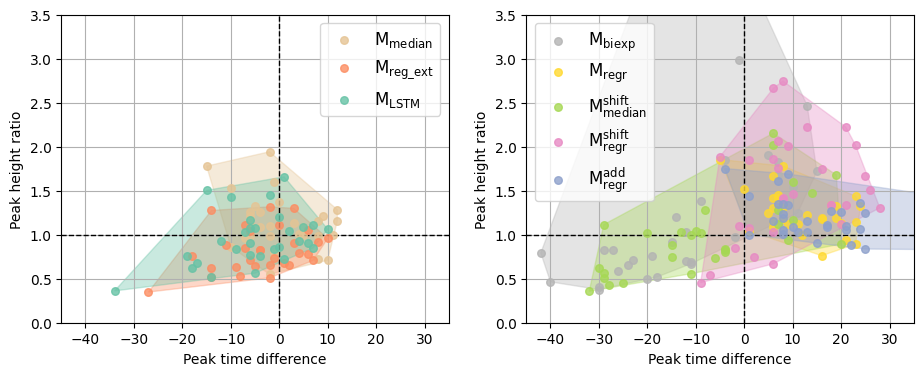

In [ ]:
from scipy.spatial import ConvexHull
import matplotlib as mpl

fig, axes = plt.subplots(1,2,figsize=(11, 4))
axes = axes.flatten()

ax = axes[1]
ax.axvline(x=0, color='black', linestyle='--', 
           linewidth=1)
ax.axhline(y=1, color='black', linestyle='--', 
           linewidth=1)

methods = ['$\mathregular{M_{biexp}}$', '$\mathregular{M_{regr}}$',

            '$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$']

new_labels = ['biexponential_decay', 'regression_day',

                'median_beta_shifted_forecast','regression_day_shifted_forecast',
                'regression_day_incremental_learning']

cmap = mpl.colormaps['Set2']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, 8))
colors = list(colors[[2,3,4,5,7]])
for name, method in zip(new_labels, methods):
    p_df = pd.read_csv(f'results/{switch}/{name}_results.csv')
    
    ph = p_df['predicted_peak_I']/p_df['actual_peak_I']
    pt = p_df['predicted_peak_day'] - p_df['actual_peak_day']
    
    hull = ConvexHull(pd.concat([pt,ph], axis=1))
    
    col = colors.pop()
    ax.scatter(pt,ph, marker='.', s=120,  alpha=.8, 
               label=method, zorder=10, color=col)

    ax.fill(pt.iloc[hull.vertices], 
             ph.iloc[hull.vertices], alpha=0.35, color=col)

ax.grid()
ax.set_xlabel('Peak time difference')
ax.set_ylabel('Peak height ratio')

ax.legend(prop={'size': 12})
ax.set_xlim(-45,35)
ax.set_ylim(0,3.5)

# ____________
ax = axes[0]

ax.axvline(x=0, color='black', linestyle='--', 
           linewidth=1)
ax.axhline(y=1, color='black', linestyle='--', 
           linewidth=1)

cmap = mpl.colormaps['Set2']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, 8))

colors = [*list(colors)[:2], list(colors)[-2]]

methods = ['$\mathregular{M_{median}}$', '$\mathregular{M_{reg\_ext}}$',       
            '$\mathregular{M_{LSTM}}$']

new_labels = ['median_beta','regression_day_SEIR_previous_I',       
                'lstm_day_E_previous_I']

for name, method in zip(new_labels, methods):
    p_df = pd.read_csv(f'results/{switch}/{name}_results.csv')
    
    ph = p_df['predicted_peak_I']/p_df['actual_peak_I']
    pt = p_df['predicted_peak_day'] - p_df['actual_peak_day']
    
    hull = ConvexHull(pd.concat([pt,ph], axis=1))
    
    col = colors.pop()
    ax.scatter(pt,ph, marker='.', s=120,  alpha=.8, 
               label=method, zorder=10, color=col)

    ax.fill(pt.iloc[hull.vertices], 
             ph.iloc[hull.vertices], alpha=0.35, color=col)

ax.grid()
ax.set_xlabel('Peak time difference')
ax.set_ylabel('Peak height ratio')

ax.legend(prop={'size': 12})
#ax.set_xlim(-45,35)
#ax.set_ylim(0,3.5)
ax.set_xlim(-45,35)
ax.set_ylim(0,3.5)

plt.tight_layout
plt.savefig(f'results/{switch}/peaks_area.pdf', format='pdf', 
            bbox_inches='tight')

# start day - constant

In [1]:
'''
seeds = set()
seeds.update(range(int(0), int(30)))
days = np.array([40,50,60])
for day in days:
    methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
    new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']
    for beta_prediction_method,new_labels in zip(methods, new_labels):
        all_rmse_I, all_rmse_Beta, all_peak, execution_time, start_days = main_f('seir', False, 0, beta_prediction_method, day, seeds, False, False)
        # Создание датафрейма для пиков
        all_peak = pd.DataFrame(all_peak, columns=['actual_peak_I', 'predicted_peak_I', 'actual_peak_day', 'predicted_peak_day'])
        # Создание датафрейма для RMSE, time, day
        print(len(all_rmse_I),len(all_rmse_Beta), len(execution_time), len(start_days))
        rmse_df = pd.DataFrame({
            'rmse_I': all_rmse_I,
            'rmse_Beta': all_rmse_Beta,
            'time_predict': execution_time,
            f'{day}': start_days})

        # Объединение датафреймов
        results = pd.concat([rmse_df, all_peak], axis=1)
        results.to_csv(f'results/start_day = {day}/{new_labels}_results.csv', index=False)
        '''

"\nseeds = set()\nseeds.update(range(int(0), int(30)))\ndays = np.array([40,50,60])\nfor day in days:\n    methods = ['last value',\n        'rolling mean last value',\n        'expanding mean last value',\n        'biexponential decay', \n        \n        'median beta',\n        'regression (day)',\n\n        'median beta;\nshifted forecast',\n        'regression (day);\nshifted forecast',\n        'regression (day);\nincremental learning',\n        'regression (day, SEIR, previous I)',       \n        'lstm (day, E, previous I)']\n    new_labels = ['last_value',\n        'rolling_mean_last_value',\n        'expanding_mean_last_value',\n        'biexponential_decay', \n        \n        'median_beta',\n        'regression_day',\n\n        'median_beta_shifted_forecast',\n        'regression_day_shifted_forecast',\n        'regression_day_incremental_learning',\n        'regression_day_SEIR_previous_I',       \n        'lstm_day_E_previous_I']\n    for beta_prediction_method,new_label

### Boxplot RMSE for Infected


all beta_prediction_method, start_day = 40, 50, 60

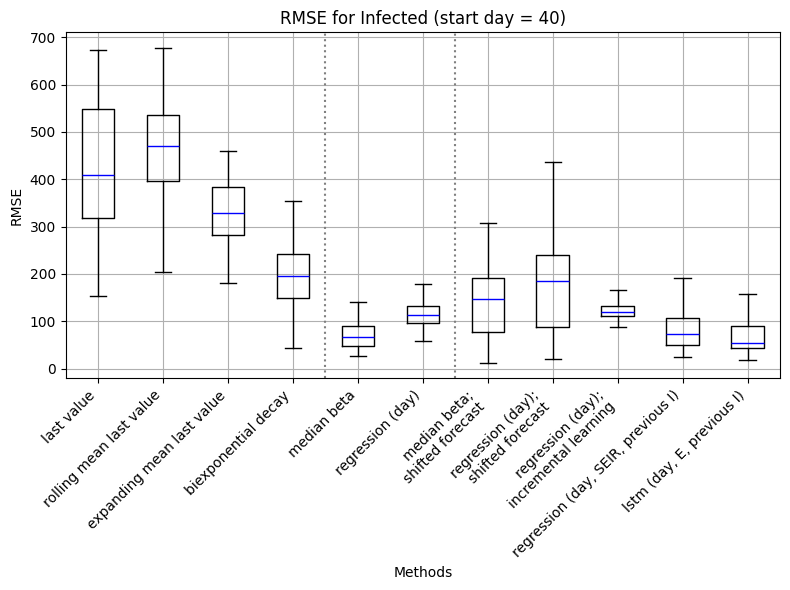

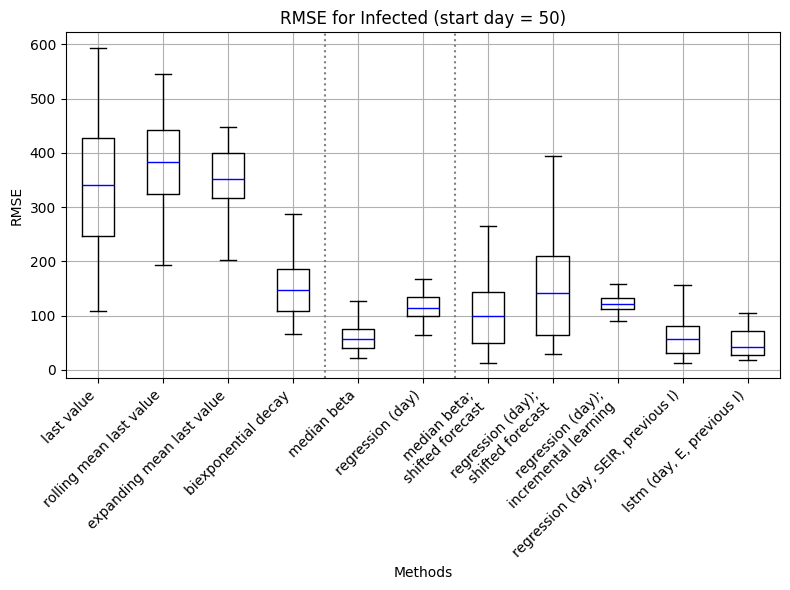

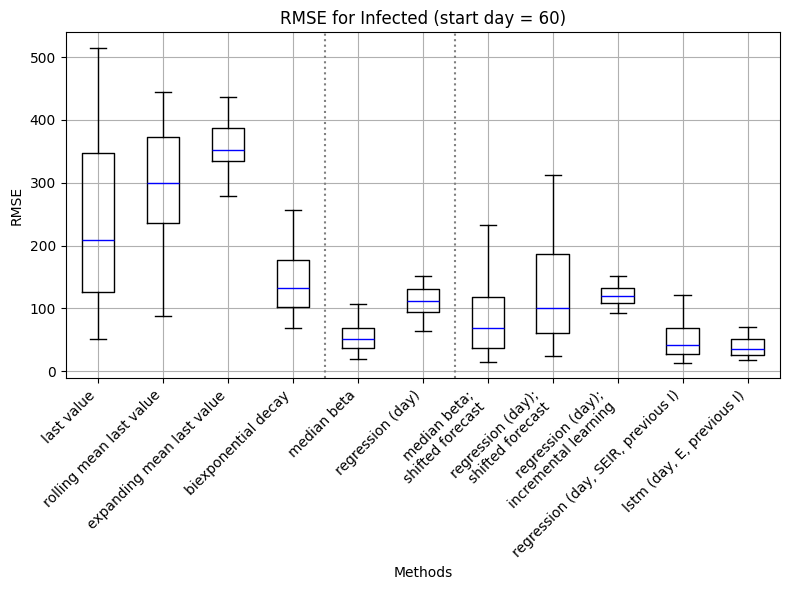

In [ ]:
days = np.array([40,50,60])
for day in days:
    methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
    new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']

    rmse_df = pd.DataFrame()
    for beta_prediction_method,new_labels in zip(methods, new_labels):
        # Загрузка данных из CSV
        df = pd.read_csv(f'results/start_day = {day}/{new_labels}_results.csv')
        # Добавляем данные в DataFrame с названием колонки как метод
        rmse_df[f"{beta_prediction_method}"] = df['rmse_I']

    # Создание боксплота
    plt.figure(figsize=(8,6))  # Установка размера графика
    box = plt.boxplot(rmse_df, showfliers=False, medianprops=dict(color='blue'),widths=0.5)

    # Настройка заголовка и меток
    plt.title(f'RMSE for Infected (start day = {day})')
    plt.xlabel('Methods')
    plt.ylabel('RMSE')

    # Поворот меток по оси X для лучшей читаемости
    plt.xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
            labels=methods, rotation=45, ha='right')

    plt.axvline(4.5, ls=':', color='gray')
    plt.axvline(6.5, ls=':', color='gray')

    # Показать график
    plt.tight_layout()  # Автоматическая настройка отступов
    plt.grid()
    plt.savefig(f'results/start_day = {day}/rmse_I_boxplot.pdf', format='pdf', dpi=300, bbox_inches='tight')    
    plt.show()

### Boxplot RMSE for Beta

all beta_prediction_method, start_day = 40, 50, 60

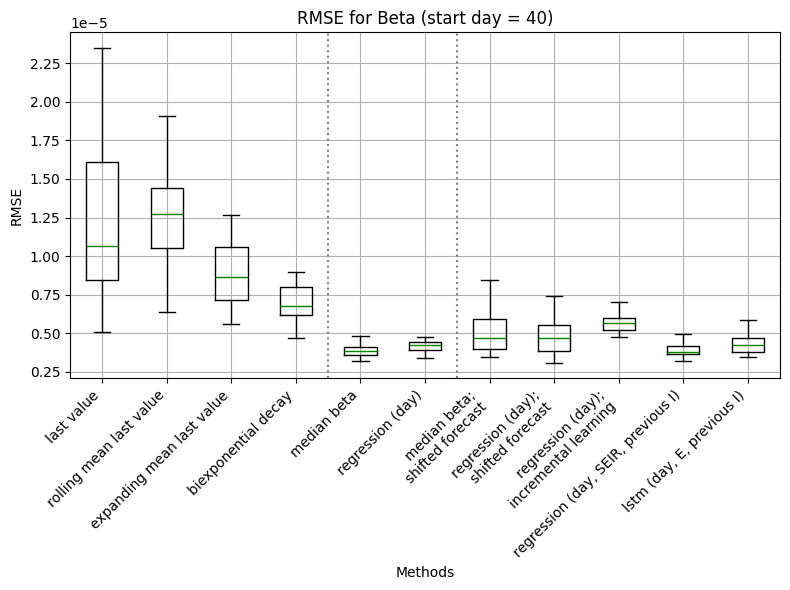

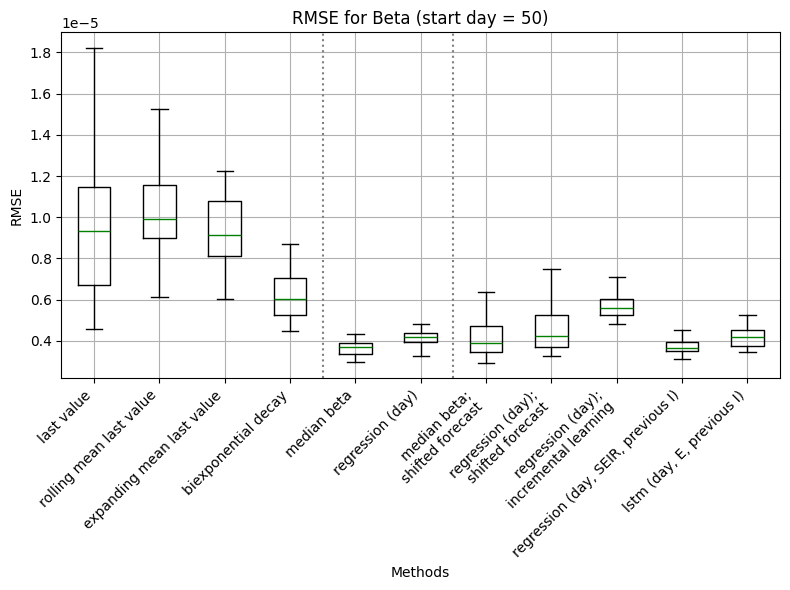

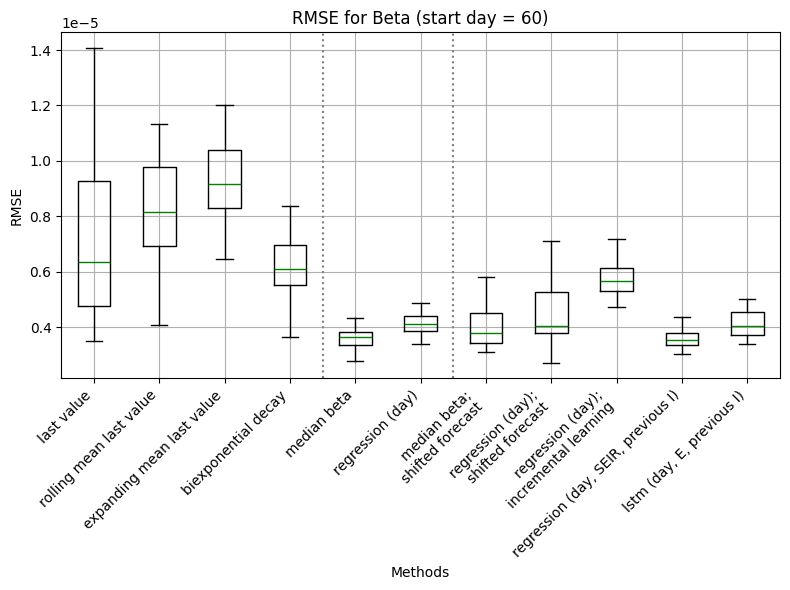

In [ ]:

days = np.array([40,50,60])
for day in days:
    rmse_df = pd.DataFrame()
    for beta_prediction_method,new_label in zip(methods, new_labels):
        # Загрузка данных из CSV
        df = pd.read_csv(f'results/start_day = {day}/{new_label}_results.csv')
        # Добавляем данные в DataFrame с названием колонки как метод
        rmse_df[f"{beta_prediction_method}"] = df['rmse_Beta']

    # Создание боксплота
    plt.figure(figsize=(8,6))  # Установка размера графика
    box = plt.boxplot(rmse_df, showfliers=False, medianprops=dict(color='green'),widths=0.5)

    # Настройка заголовка и меток
    plt.title(f'RMSE for Beta (start day = {day})')
    plt.xlabel('Methods')
    plt.ylabel('RMSE')

    # Поворот меток по оси X для лучшей читаемости
    plt.xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
            labels=methods, rotation=45, ha='right')

    plt.axvline(4.5, ls=':', color='gray')
    plt.axvline(6.5, ls=':', color='gray')

    # Показать график
    plt.tight_layout()  # Автоматическая настройка отступов
    plt.grid()
    plt.savefig(f'results/{}/rmse_Beta_boxplot.pdf', format='pdf', dpi=300, bbox_inches='tight')    
    plt.show()

### Show peaks plots

start_day = 50

In [100]:
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']
day = 50

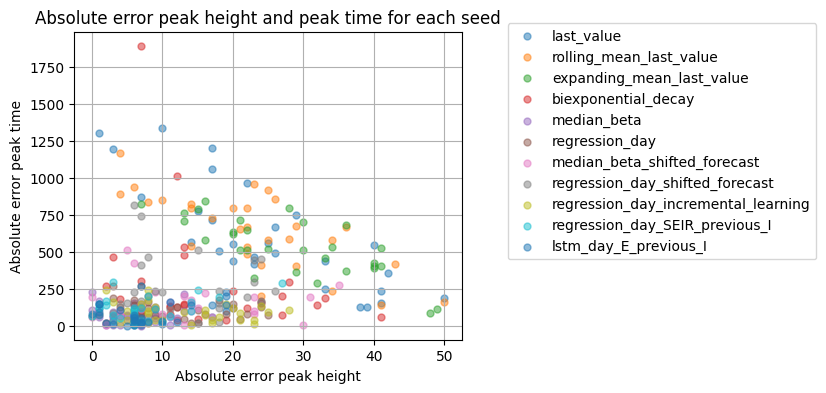

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
for name in new_labels:
    p_df = pd.read_csv(f'results/start_day = {day}/{name}_results.csv')
    
    ax.scatter(abs(p_df['actual_peak_day']-p_df['predicted_peak_day']),
               abs(p_df['actual_peak_I']-p_df['predicted_peak_I']),
               marker='.', s=100,  alpha=0.5, label=name)
    
ax.set_title('Absolute error peak height and peak time for each seed')    
ax.set_xlabel('Absolute error peak height')
ax.set_ylabel('Absolute error peak time')
ax.legend(bbox_to_anchor=(1.1, 1.05))

ax.grid()
plt.savefig(f'results/start_day = {day}/absolute_error_peaks.pdf', format='pdf', dpi=300, bbox_inches='tight')

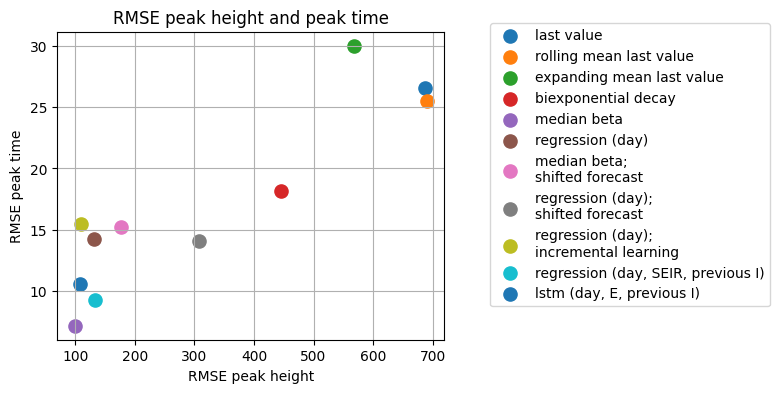

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
rmse_ph = []
rmse_pt = []
for name in new_labels:
    p_df = pd.read_csv(f'results/start_day = {day}/{name}_results.csv')
    rmse_ph.append(rmse(p_df.iloc[:]['actual_peak_I'], p_df.iloc[:]['predicted_peak_I']))
    rmse_pt.append(rmse(p_df.iloc[:]['actual_peak_day'], p_df.iloc[:]['predicted_peak_day']))
    
for i, name in enumerate(methods):   
    ax.scatter(rmse_ph[i], rmse_pt[i], marker='o', s=90, label=name)
    
ax.set_title('RMSE peak height and peak time')    
ax.set_xlabel('RMSE peak height')
ax.set_ylabel('RMSE peak time')
ax.legend(bbox_to_anchor=(1.1, 1.05))

ax.grid()

plt.savefig(f'results/start_day = {day}/rmse_peaks.pdf', format='pdf', dpi=300, bbox_inches='tight')


# pivot tables for all models and switches

In [61]:
# save by switch method

new_labels = ['last_value', 'rolling_mean_last_value',
                'expanding_mean_last_value','biexponential_decay', 

                'median_beta','regression_day',

                'median_beta_shifted_forecast','regression_day_shifted_forecast',
                'regression_day_incremental_learning','regression_day_SEIR_previous_I',       
                'lstm_day_E_previous_I']


switches = [f'start_day = {n}' for n in [40,50,60]] + \
            [f'type_start_day = {i}' for i in ['norm_var','roll_var',
                                               'roll_var_npeople','roll_var_seq']]

for switch in switches:
    fin = pd.DataFrame([])
    
    clm_with_switch = switch.split(' = ')[-1]
    clms = ['rmse_I', 'rmse_Beta', 'time_predict', clm_with_switch]
    for m in new_labels:
        df = pd.read_csv(f'results/{switch}/{m}_results.csv')

        q = df[clms].apply(lambda x: [x.median(), x.std()]).T
        ph = df['predicted_peak_I'] - df['actual_peak_I']
        q.loc['pt_diff'] = ph.median(), ph.std()
        pt = df['actual_peak_I']/df['predicted_peak_I']
        q.loc['ph_fraq'] = pt.median(), pt.std()
        q.columns = [[m + '_mean', m + '_std']]
        fin = pd.concat([fin, q], axis=1)
    fin.to_csv(f'results/pivot_tables/{clm_with_switch}_pivot.csv')

# switches for 12 and 29 seed


$\mathregular{SP_{once}}$ 10
$\mathregular{SP_{establ}}$ 63
$\mathregular{SP_{epi\_sit}}$ 63
$\mathregular{SP_{once}}$ 87
$\mathregular{SP_{establ}}$ 87
$\mathregular{SP_{epi\_sit}}$ 60


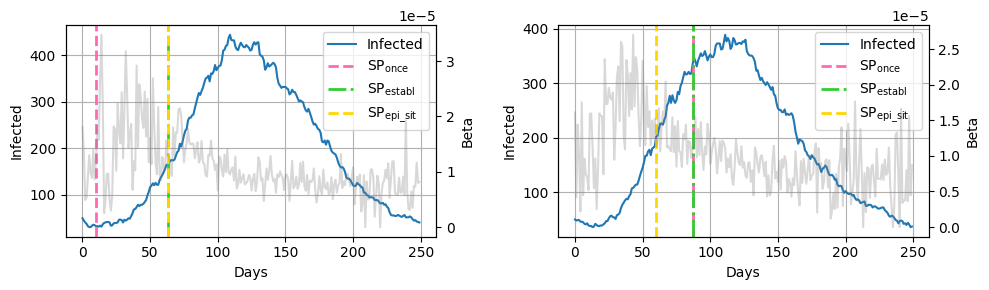

In [67]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax = ax.flatten()

for i,seed_number in enumerate([12,29]):
    seed_df = pd.read_csv(f'seir_30_seeds_v0/seir_seed_{seed_number}.csv')
    seed_df = seed_df[pd.notna(seed_df['Beta'])]

    # отображение реальных значений Infected
    ax[i].plot(seed_df.index, seed_df['I'].values , color='tab:blue', 
                label='Infected')
    ax_b = ax[i].twinx()
    # отображение реальных значений beta
    ax_b.plot(seed_df.index, seed_df['Beta'],  color='gray', ls='-', 
                  alpha=0.3, label='Beta')
    ax[i].grid()
    colors=['gold','limegreen','hotpink']
    lss=['--','-.','--']
    for sm, lab in zip(['roll_var','roll_var_seq','roll_var_npeople'],
                        ['$\mathregular{SP_{once}}$', 
                         '$\mathregular{SP_{establ}}$', 
                         '$\mathregular{SP_{epi\_sit}}$']):
        c = colors.pop()
        start_day = choice_start_day.choose_method(seed_df, sm)
        ax[i].axvline(start_day, color=c, alpha=1, 
                   lw=2, label=lab, ls=lss.pop())
        print(lab, start_day)

    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Infected')
    ax_b.set_ylabel('Beta')

    ax[i].legend(loc='upper right')
    
plt.tight_layout()
plt.savefig(f'results/12_and_29_seeds_switches.pdf',  
            format='pdf', bbox_inches='tight')

# several constant Beta

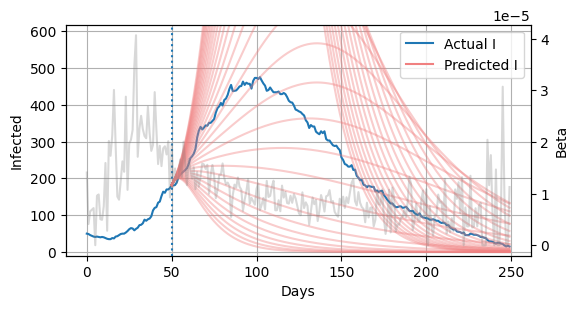

In [75]:
betas = np.arange(0, 3e-5, 1e-6)

seed_number = 0
seed_df = pd.read_csv(f'seir_30_seeds_v0/seir_seed_{seed_number}.csv')
seed_df = seed_df[pd.notna(seed_df['Beta'])]

fig, ax = plt.subplots(1,1, figsize=(6,3))
ax.plot(seed_df.index, seed_df['I'].values , color='tab:blue', 
                label='Actual I')

ax_b = ax.twinx()
    # отображение реальных значений beta
ax_b.plot(seed_df.index, seed_df['Beta'],  color='gray', ls='-', 
                  alpha=0.3, label='Beta')
start_day = 50

ax.axvline(start_day, ls=':')
y = seed_df.iloc[start_day, :4].values
predicted_days = np.arange(start_day, seed_df.shape[0])

for beta in betas:
    if beta == 0:
        label='Predicted I'
    else:
        label=''
    S,E,I,R = predict_Beta_I.predict_I('seir',y, predicted_days, beta, 
                                       0.1, 0.08, stype='d', beta_t=False)
    ax.plot(np.arange(start_day, seed_df.shape[0]), I, 
            color='lightcoral', alpha=0.4, label=label)
    
ll = ax.legend()
for lh in ll.legend_handles:
    lh.set_alpha(1)
ax.set_xlabel('Days')
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')

ax.set_ylim(-10, seed_df.I.max()*1.3)
ax.grid()

plt.savefig(f'results/several_constant_Beta.pdf',  
            format='pdf', bbox_inches='tight')

# 5 seed graphs for beta_prediction_method groups with start_day = 50

group 1

last value
rolling mean last value
expanding mean last value
biexponential decay


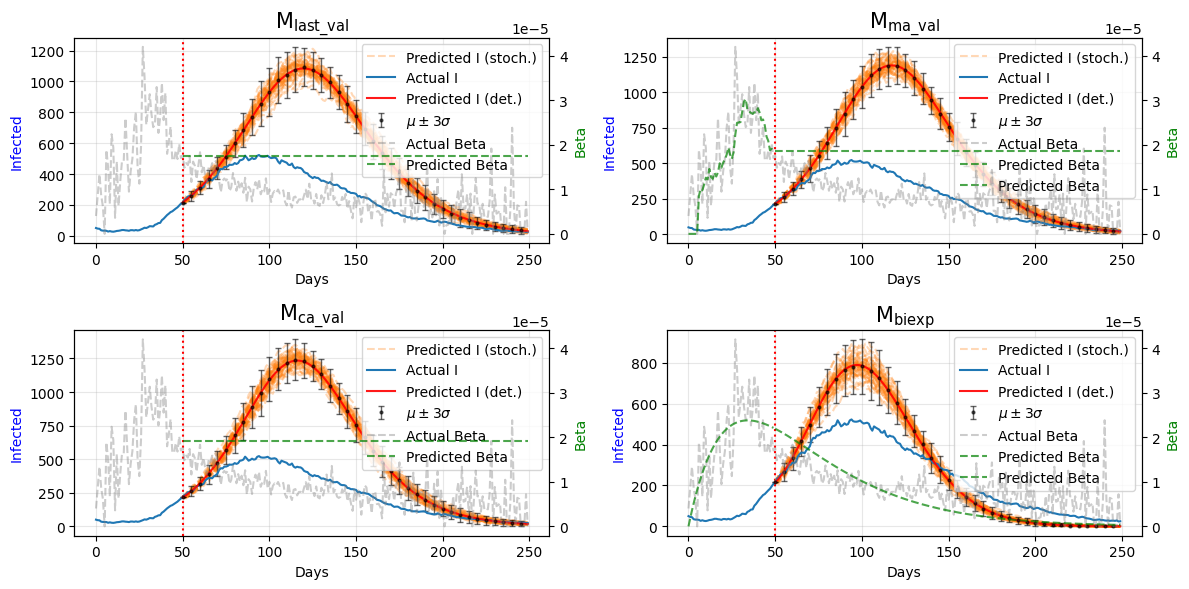

In [94]:

methods = ['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$', 

    '$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$',

    '$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']
new_labels = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 

    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']

n_s = 50
seeds = set()
seeds.update(range(int(5), int(6)))
seed_number = next(iter(seeds))
seed_df = pd.read_csv(f'seir_30_seeds_v0/seir_seed_{seed_number}.csv')
seed_df = seed_df[pd.notna(seed_df['Beta'])]

fig, ax = plt.subplots(2,2, figsize=(12,6))
axes=ax.flatten()

n = 4

for beta_method, label, i in zip(new_labels[:n], methods[:n], range(n)):
    seeds = set()
    seeds.update(range(int(5), int(6)))
    seed_number = seeds
    predicted_days, seed_df, predicted_I, beggining_beta, predicted_beta, seed_number, ttime = main_f('seir', True, n_s, 
                           beta_method, 50, seed_number, False, False)

    # Рассчитаем медиану и интерквартильный размах
    median_values = np.median(predicted_I, axis=0)  # Медиана по всем I[j]
    std_dev = np.std(predicted_I[:, :], axis=0, ddof=1)  # Выборочное стандартное отклонение
    n = predicted_I.shape[0]  # Размер выборки

    # Стандартная ошибка
    std_dev = np.std(predicted_I, axis=0)

    # Границы: медиана ± 3σ (с проверкой на отрицательные значения)
    lower_bound = median_values - 3 * std_dev
    upper_bound = median_values + 3 * std_dev
    lower_bound = np.maximum(lower_bound, 0)  # Если значения не могут быть < 0
  

    plot_one(axes[i], predicted_days, seed_df, 
               predicted_I, beggining_beta, predicted_beta, 
               seed_number, ttime, median_values,lower_bound,upper_bound)
    axes[i].set_title(f"{label}",size=15)

plt.tight_layout()  
plt.savefig(f'results/3sigma_group1.pdf',  format='pdf', bbox_inches='tight')

group 2

median beta
regression (day)


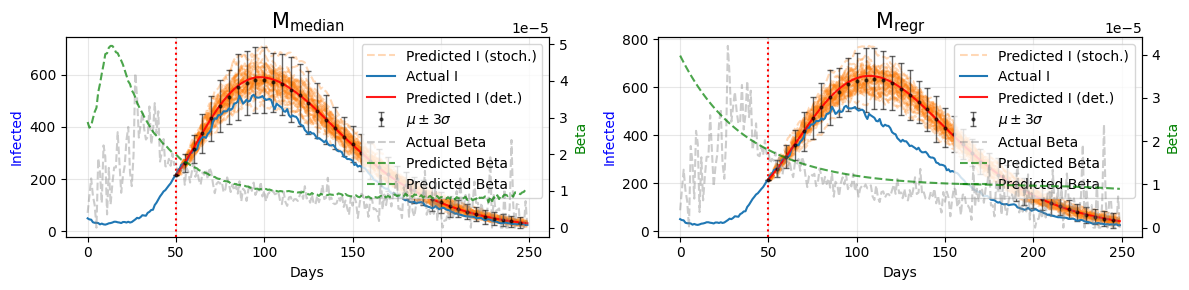

In [96]:

methods = ['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$', 

    '$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$',

    '$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']
new_labels = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 

    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']

n_s = 50
seeds = set()
seeds.update(range(int(5), int(6)))
seed_number = next(iter(seeds))
seed_df = pd.read_csv(f'seir_30_seeds_v0/seir_seed_{seed_number}.csv')
seed_df = seed_df[pd.notna(seed_df['Beta'])]

fig, ax = plt.subplots(1,2, figsize=(12,3))
axes=ax.flatten()

n = 2

for beta_method, label, i in zip(new_labels[4:6], methods[4:6], range(n)):
    seeds = set()
    seeds.update(range(int(5), int(6)))
    seed_number = seeds
    predicted_days, seed_df, predicted_I, beggining_beta, predicted_beta, seed_number, ttime = main_f('seir', True, n_s, 
                           beta_method, 50, seed_number, False, False)

    # Рассчитаем медиану и интерквартильный размах
    median_values = np.median(predicted_I, axis=0)  # Медиана по всем I[j]
    std_dev = np.std(predicted_I[:, :], axis=0, ddof=1)  # Выборочное стандартное отклонение
    n = predicted_I.shape[0]  # Размер выборки

    # Стандартная ошибка
    std_dev = np.std(predicted_I, axis=0)

    # Границы: медиана ± 3σ (с проверкой на отрицательные значения)
    lower_bound = median_values - 3 * std_dev
    upper_bound = median_values + 3 * std_dev
    lower_bound = np.maximum(lower_bound, 0)  # Если значения не могут быть < 0
  

    plot_one(axes[i], predicted_days, seed_df, 
               predicted_I, beggining_beta, predicted_beta, 
               seed_number, ttime, median_values,lower_bound,upper_bound)
    axes[i].set_title(f"{label}",size=15)

plt.tight_layout()  
plt.savefig(f'results/3sigma_group2.pdf',  format='pdf', bbox_inches='tight')

group 3

median beta;
shifted forecast
regression (day);
shifted forecast
regression (day);
incremental learning
regression (day, SEIR, previous I)
lstm (day, E, previous I)


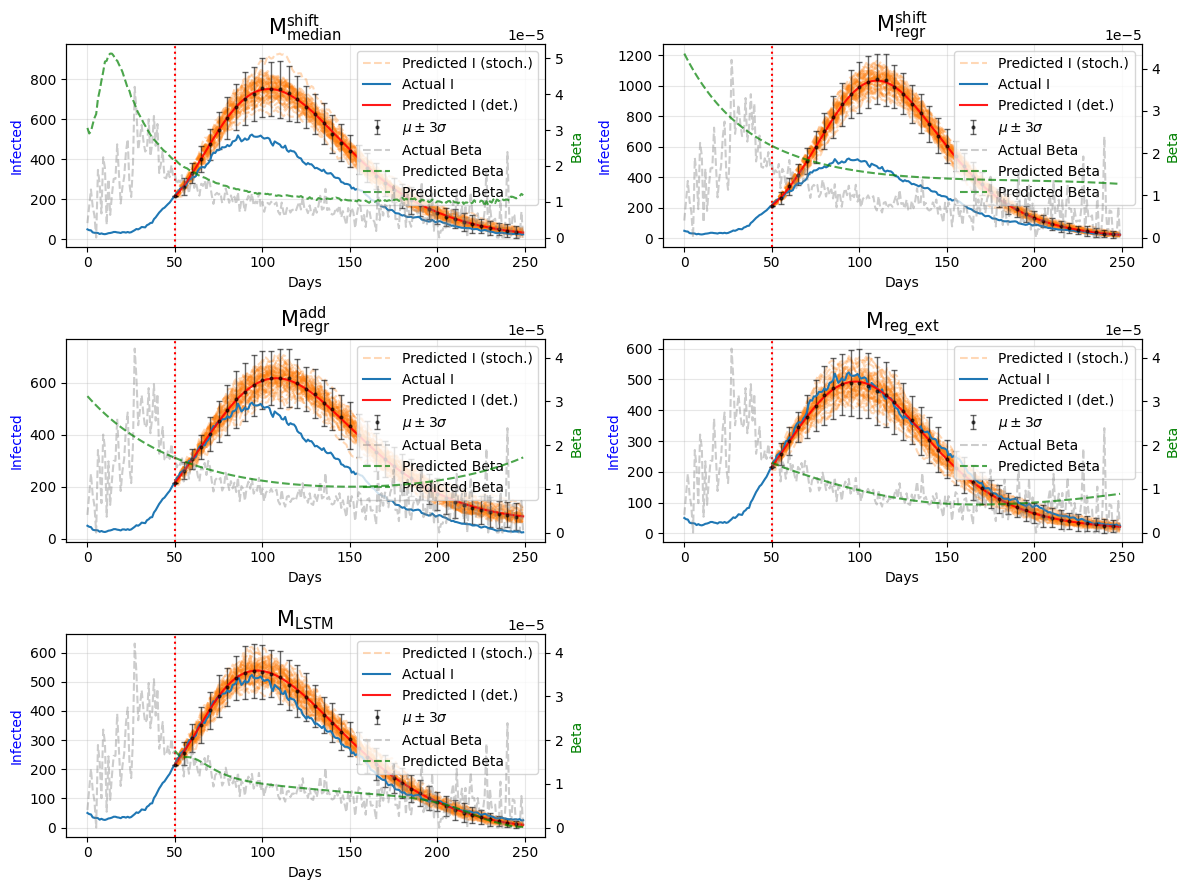

In [99]:

methods = ['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$', 

    '$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$',

    '$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']
new_labels = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 

    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']

n_s = 50
seeds = set()
seeds.update(range(int(5), int(6)))
seed_number = next(iter(seeds))
seed_df = pd.read_csv(f'seir_30_seeds_v0/seir_seed_{seed_number}.csv')
seed_df = seed_df[pd.notna(seed_df['Beta'])]

fig, ax = plt.subplots(3,2, figsize=(12,9))
axes=ax.flatten()

n = 6

for beta_method, label, i in zip(new_labels[6:], methods[6:], range(n)):
    seeds = set()
    seeds.update(range(int(5), int(6)))
    seed_number = seeds
    predicted_days, seed_df, predicted_I, beggining_beta, predicted_beta, seed_number, ttime = main_f('seir', True, n_s, 
                           beta_method, 50, seed_number, False, False)

    # Рассчитаем медиану и интерквартильный размах
    median_values = np.median(predicted_I, axis=0)  # Медиана по всем I[j]
    std_dev = np.std(predicted_I[:, :], axis=0, ddof=1)  # Выборочное стандартное отклонение
    n = predicted_I.shape[0]  # Размер выборки

    # Стандартная ошибка
    std_dev = np.std(predicted_I, axis=0)

    # Границы: медиана ± 3σ (с проверкой на отрицательные значения)
    lower_bound = median_values - 3 * std_dev
    upper_bound = median_values + 3 * std_dev
    lower_bound = np.maximum(lower_bound, 0)  # Если значения не могут быть < 0
  

    plot_one(axes[i], predicted_days, seed_df, 
               predicted_I, beggining_beta, predicted_beta, 
               seed_number, ttime, median_values,lower_bound,upper_bound)
    axes[i].set_title(f"{label}",size=15)

fig.delaxes(axes[-1])   
plt.tight_layout()  
plt.savefig(f'results/3sigma_group3.pdf',  format='pdf', bbox_inches='tight')

# Код графического окна

last value


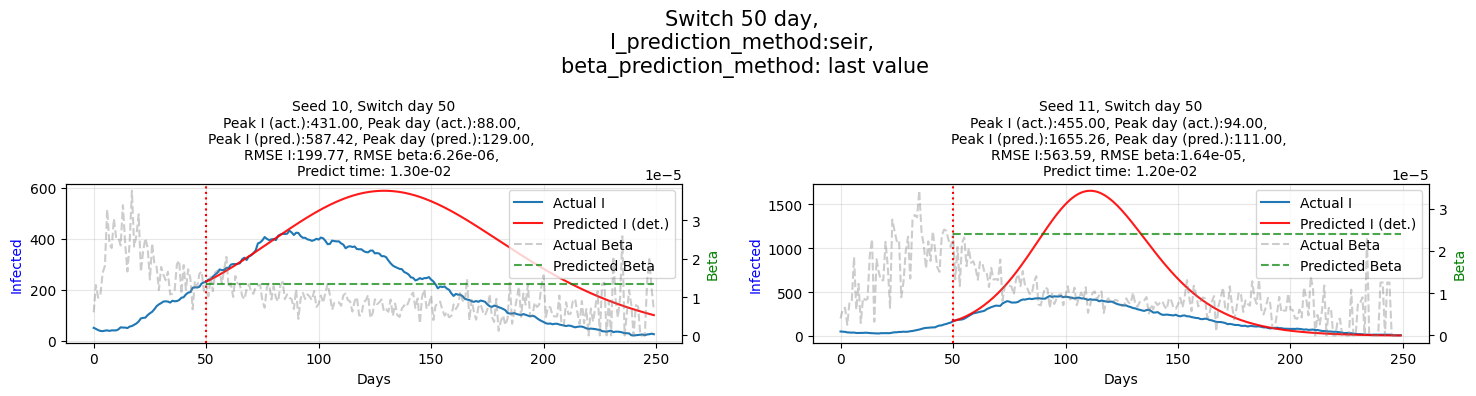

In [112]:
'''
Создание графического окна для ввода параметров
'''
def parse_seeds(seeds_input):
    ''' 
    Сортировка numbers of seeds
    '''

    # использование множества уникальных значений
    seeds = set()  
   
    parts = seeds_input.split(',') 
    for part in parts:
        if '-' in part:  # определение диапазона по тире
            start, end = part.split('-')
            seeds.update(range(int(start), int(end)))  # добавление чисел из диапазона
        else:
            seeds.add(int(part))  # добавление отдельных номеров seed
            
    return sorted(seeds)

def calculate():
    try:
        # получение значениий из полей ввода
        I_prediction_method = var_I_prediction_method.get()
        stochastic = var_stochastic.get()
        # получение количества случайных траекторий, если включена стохастичность
        count_stoch_line = int(entry_count_stoch_line.get()) if stochastic else 0  
        beta_prediction_method = var_beta_prediction_method.get()
        # получение значения дня начала
        start_day = selected_start_day.get()

        # Преобразуем выбранное значение дня в число, если это '40', '50' или '60'
        if start_day in ['40', '50', '60']:
            start_day = int(start_day)
        else:
            # Если выбрано что-то другое, оставляем как есть (это строка)
            start_day = start_day

        seed_numbers = entry_seed_numbers.get()
        # сортировка numbers of seeds
        seed_numbers = parse_seeds(seed_numbers)
        
        # вызов основной функции
        result = main_f(I_prediction_method, stochastic, count_stoch_line, 
                        beta_prediction_method, start_day, seed_numbers,
                        True, False)
        
        # вывод результата
        messagebox.showinfo("Результат", "Выполнено")
    except ValueError:
        messagebox.showerror("Ошибка", "Пожалуйста, введите корректные данные.")
    except Exception as e:
        messagebox.showerror("Ошибка", f"Произошла ошибка: {str(e)}")

# создание главного окна
root = tk.Tk()
root.title("Ввод параметров")

# создание переменной для выбора мат. модели
var_I_prediction_method = tk.StringVar(value="seir")  # установка значения по умолчанию
# создание выпадающего списока для выбора мат. модели
label_I_prediction_method = tk.Label(root, text="Метод предсказания Infected:")
label_I_prediction_method.pack()
I_prediction_method_options = ["seir"]
dropdown_I_prediction_method = tk.OptionMenu(root, var_I_prediction_method, 
                                             *I_prediction_method_options)
dropdown_I_prediction_method.pack()

# создание флажка для стохастичности
var_stochastic = tk.BooleanVar(value=False)
checkbox_stochastic = tk.Checkbutton(root, text="Стохастичность", 
                                     variable=var_stochastic, 
                                     command=lambda: toggle_stochastic_entry())
checkbox_stochastic.pack()

# создание метки и поля ввода для количество стохастических траекторий
label_count_stoch_line = tk.Label(root, text="Количество случайных траекторий:")
label_count_stoch_line.pack()
entry_count_stoch_line = tk.Entry(root)
entry_count_stoch_line.pack()
entry_count_stoch_line.config(state='disabled')  # изначальное отключение поле ввода
# функция для включения/выключения поля ввода в зависимости от состояния флажка
def toggle_stochastic_entry():
    if var_stochastic.get():
        entry_count_stoch_line.config(state='normal')  # включение поля ввода
    else:
        entry_count_stoch_line.config(state='disabled')  # отключение поля ввода

# создание переменной для выбора метода предсказания значений Beta
# Устанавливаем значение по умолчанию
var_beta_prediction_method = tk.StringVar(value="last value") 
# создание выпадающего список для выбора метода
label_beta_prediction_method = tk.Label(root, text="Метод предсказания Beta:")
label_beta_prediction_method.pack()
beta_prediction_method_options =  ['last_value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)'

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
dropdown_beta_prediction_method = tk.OptionMenu(root, var_beta_prediction_method, 
                                                *beta_prediction_method_options)
dropdown_beta_prediction_method.pack()

# создание метки типа дня переключения на мат. модель
# переменная для выбора типа дня начала
selected_start_day = tk.StringVar(value='50')

# создание выпадающего списка для выбора типа дня начала
label_start_day = tk.Label(root, text="Тип вычисления дня переключения на мат. модель:")
label_start_day.pack()

start_day_options = ['roll_var', 
                     'norm_var', 
                     'roll_var_seq', 
                     'roll_var_npeople', 
                     '40',
                     '50',
                     '60']
dropdown_start_day = tk.OptionMenu(root, selected_start_day, *start_day_options)
dropdown_start_day.pack()

# создание метки и поля ввода для numbers of seeds
label_seed_numbers = tk.Label(root, 
                              text="Seed_numbers (через запятую или диапазон через тире):")
label_seed_numbers.pack()
entry_seed_numbers = tk.Entry(root)
entry_seed_numbers.pack()

# создание кнопки для выполнения вычисления
button_calculate = tk.Button(root, text="Вычислить", command=calculate)
button_calculate.pack() 

# запуск главного цикла приложения
root.mainloop()